In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Layer, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from IPython.display import Image
from collections import deque
from statsmodels.tsa.arima_model import ARIMA
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
import copy
import random
import pickle
import time
import os
import io
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

# This removes error from the custom keras-layer
tf.compat.v1.disable_eager_execution()

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

config = {
    'embed_dim': 300,    # Dimensions to use for the word embedding
    'lookback': 1,       # Set to 1 since this model doesn't use any recurrent method
    'delay': 1,          # How far ahead to predict data (days)
    'batch_size': 10,    # Batch size used in generator
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.8,  # Part of data to be used for training
    'val_part' : 0.1,    # Part of data to be used for validation
    'test_part' : 0.1,   # Part of data to be used for testing
    'series': '1 YEAR',  # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'vocab_size': 15000, # Include only the 'vocab_size' most common words 
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [3]:
# Load data 
news_path = ONEDRIVE_PATH / "Input data/financial_headlines_20061020-20131119.pkl"
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)
text = Utilities.preprocess_text(data)

In [4]:
# Tokenize the text data 
tokenizer = Tokenizer(num_words=config['vocab_size'])
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)

In [5]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = ONEDRIVE_PATH / "Embeddings/GloVe/saved.42B.300d.pkl"
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [6]:
# Create embedding matrix with shape (vocab_size, embed_dimension)
embedding_weights = np.zeros((config['vocab_size'], config['embed_dim']))
# Add pre-trained weights from GloVe
for word,index in word_index.items(): 
    if index > config['vocab_size']: 
        break
    temp_emb = emb_dict.get(word)
    if temp_emb is not None: 
        embedding_weights[index - 1] = temp_emb
    else: 
        embedding_weights[index - 1] = np.random.normal(size=config['embed_dim'])

In [7]:
config['max_len'] = max([len(sent) for sent in sequences])
print("Actual maximum length of one day news:",config['max_len'])
#config['max_len'] = 600
print("Used maximum length of one day news:",config['max_len'])

# Pad the text data so we get a matrix of shape (n,d)
x = np.zeros((len(sequences), config['max_len']))
for i,sent in enumerate(sequences): 
    if len(sent) > config['max_len']: 
        x[i] = sent[:config['max_len']]
    else: 
        x[i,:len(sent)] = sent

Actual maximum length of one day news: 950
Used maximum length of one day news: 950


Loaded previously constructed labels. 


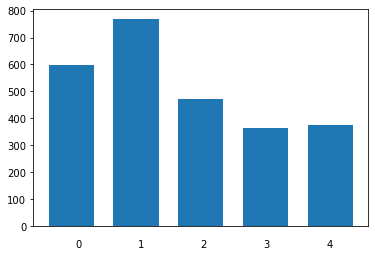

In [8]:
# Pick thresholds for the classes. Observe that these are normalized values, 
# so it's the distribution rather than the numbers that's important. 
thresholds = [-0.002,-0.0004,0.0004,0.002]
nbr_classes = len(thresholds) + 1
y = Utilities.load_multiclass_labels(config,thresholds,plot=True)

In [9]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y,test_part=config['test_part'])
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2317, 950)
Shape of y_train:  (2317,)


## Model
We create a model similar to the one in "MLP-PreTrained", except for the initial Embedding-layer from Keras. A custom layer is defined to average the embedding of all words in one training sample after the embedding layer. 

In [10]:
# Define some help functions for custom layer and hyper parameter optimization

# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]

def create_nn(n_nodes, lr=0.01): 
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential() 
    model.add(Embedding(input_dim=config['vocab_size'],
                       output_dim=config['embed_dim'],
                        input_length=config['max_len'],
                       weights=[embedding_weights]))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    for n in n_nodes: 
        model.add(Dense(n))
    model.add(Dense(nbr_classes,activation='softmax'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes,lr,verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_acc'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs, lr], 
                                                name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))


In [11]:
n_layers = [2]
n_nodes = [10]
learning_rates = [0.001]
batch_sizes = [8]
epochs = 20
show_progress = 1
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes', 'Batch Size', 'Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    # Ugliest code ever written, fix?
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs: 
            for lr in learning_rates:
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes,lr,verbose=show_progress)
                if show_progress:
                    print("{} %     ".format(round(100 * ctr / n_configs,2)))    
                else:
                    print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')


Testing 1 combinations. 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1853 samples, validate on 464 samples
Epoch 1/20
1853/1853 [==============================] - 7s 4ms/sample - loss: 1.5733 - acc: 0.2920 - val_loss: 1.5434 - val_acc: 0.3190
Epoch 2/20
1853/1853 [==============================] - 8s 4ms/sample - loss: 1.5664 - acc: 0.2887 - val_loss: 1.5450 - val_acc: 0.3233
Epoch 3/20
1853/1853 [==============================] - 7s 4ms/sample - loss: 1.5590 - acc: 0.2979 - val_loss: 1.5469 - val_acc: 0.3276
Epoch 4/20
1853/1853 [==============================] - 7s 4ms/sample - loss: 1.5516 - acc: 0.3130 - val_loss: 1.5369 - val_acc: 0.3341
Epoch 5/20
1853/1853 [==============================] - 8s 4ms/sample - loss: 1.5390 - acc: 0.3125 - val_loss: 1.5310 - val_acc: 0.3297
Epoch 6/20
1853/1853 [==============================] - 8s 4ms/sample - loss: 1.5164 - acc: 0.3276 - val_loss: 1.5270 - val_acc: 0.3362
Epoch 7/20
1853/1853 [=========

In [12]:
k = 1
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 1 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"8_2_(10, 10)",0.322845,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(10, 10)",8,0.001


Nodes: (10, 10), Mean validation accuracy: 0.32284483313560486


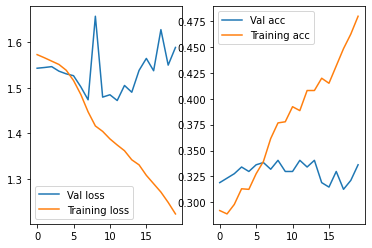

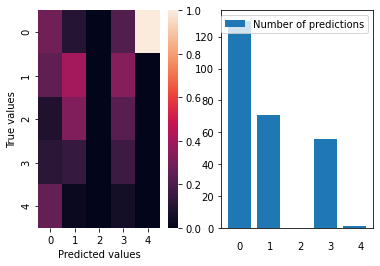

In [13]:
for i in k_best: 
    print(f"Nodes: {results.iloc[i]['Nodes']}, Mean validation accuracy: {results.iloc[i]['Mean Val Acc']}")
    plt.subplot(121)
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    results.iloc[i]['Model'].evaluate(x_test,y_test,verbose=0)
    # Calculate the predictions on the test set 
    y_test_pred_prob = model.predict(x_test)
    y_test_pred = np.zeros(len(y_test))
    for i,row in enumerate(y_test_pred_prob): 
        y_test_pred[i] = np.argmax(row)
        
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    plt.subplot(121)
    ax = sn.heatmap(conf_mat)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    Utilities.plot_multi_predictions(y_test_pred, nbr_classes,subplot=122,show=True)

In [15]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.29      0.66      0.40        58
         1.0       0.41      0.36      0.38        80
         2.0       0.00      0.00      0.00        47
         3.0       0.16      0.26      0.20        34
         4.0       0.00      0.00      0.00        39

    accuracy                           0.29       258
   macro avg       0.17      0.26      0.20       258
weighted avg       0.21      0.29      0.24       258

